In [1]:
import torch
import umap
import numpy as np
from sklearn.cluster import KMeans
import json
import matplotlib.pyplot as plt
from datetime import datetime
import os

# === 1. Load SloBERTa embeddings ===
embeddings = torch.load("train/sloberta_embeddings.pt")  # Tensor of shape [N, D]
embeddings_np = embeddings.cpu().numpy()

# === 2. UMAP projection to 50D ===
umap_model = umap.UMAP(n_components=50, random_state=42)
embeddings_50d = umap_model.fit_transform(embeddings_np)

# === 3. KMeans clustering ===
kmeans = KMeans(n_clusters=15, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_50d)
centroids = kmeans.cluster_centers_

# === 4. Save centroids ===
np.save("cluster_centroids.npy", centroids)

# === 5. Load article metadata ===
with open("../data/rtvslo_train.json", "r", encoding="utf-8") as f:
    articles = json.load(f)

assert len(articles) == len(cluster_labels), "Mismatch between articles and embeddings"

# === 6. Assign cluster labels to articles ===
for article, label in zip(articles, cluster_labels):
    article["cluster"] = int(label)  # ensure it's JSON serializable

# Optional: Save the articles with cluster labels
with open("articles_with_clusters.json", "w", encoding="utf-8") as f:
    json.dump(articles, f, ensure_ascii=False, indent=2)

# === 7. Plot comments over time for each cluster ===
os.makedirs("cluster_plots", exist_ok=True)

for cluster_id in range(15):
    cluster_articles = [a for a in articles if a["cluster"] == cluster_id]

    dates = [datetime.fromisoformat(a["date"]) for a in cluster_articles]
    comments = [a["n_comments"] for a in cluster_articles]

    plt.figure(figsize=(12, 6))
    plt.scatter(dates, comments, alpha=0.5)
    plt.title(f"Cluster {cluster_id} — {len(cluster_articles)} articles")
    plt.xlabel("Date")
    plt.ylabel("Number of Comments")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"cluster_plots/cluster_{cluster_id}.png")
    plt.close()

print("✅ Done: Centroids saved, articles clustered, plots generated.")


/home/matjaz/.conda/envs/IS2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-29 11:05:38.218777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-29 11:05:38.359636: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-29 11:05:38.399015: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-29 11:05:38.684584: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binar

✅ Done: Centroids saved, articles clustered, plots generated.


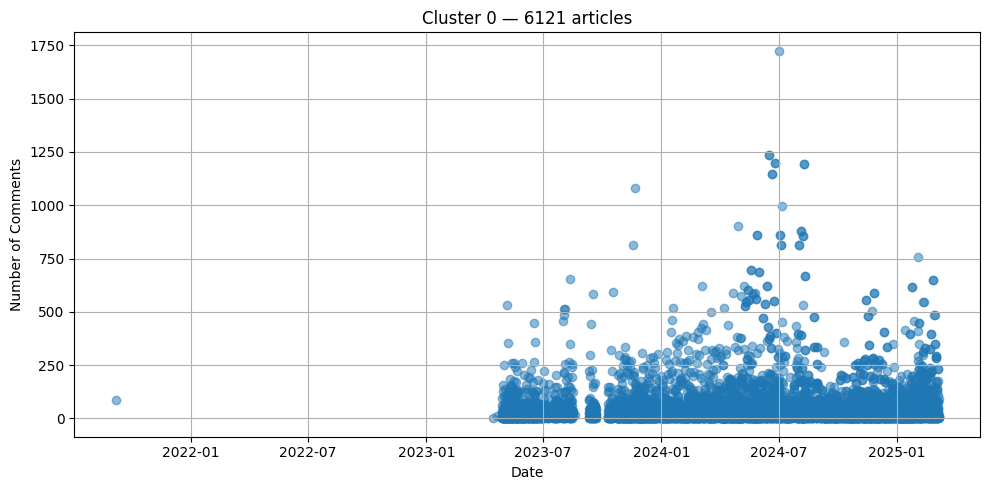

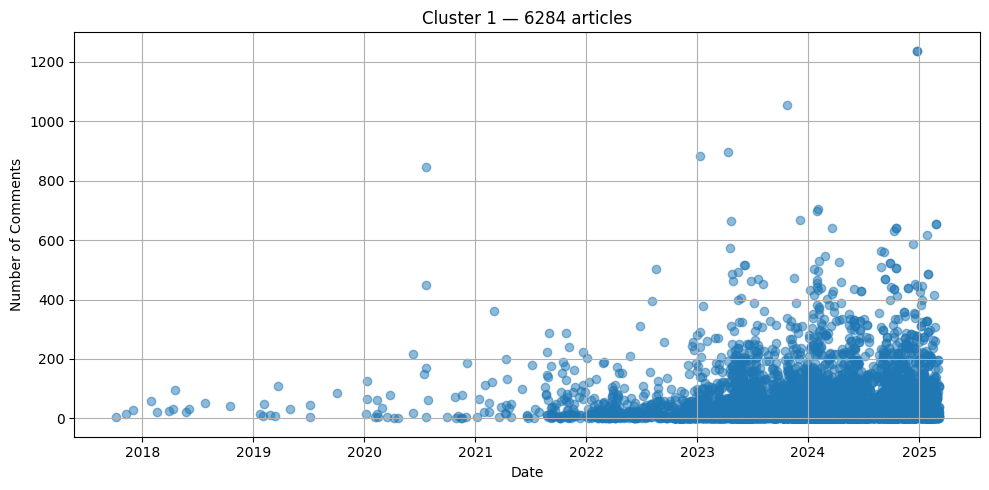

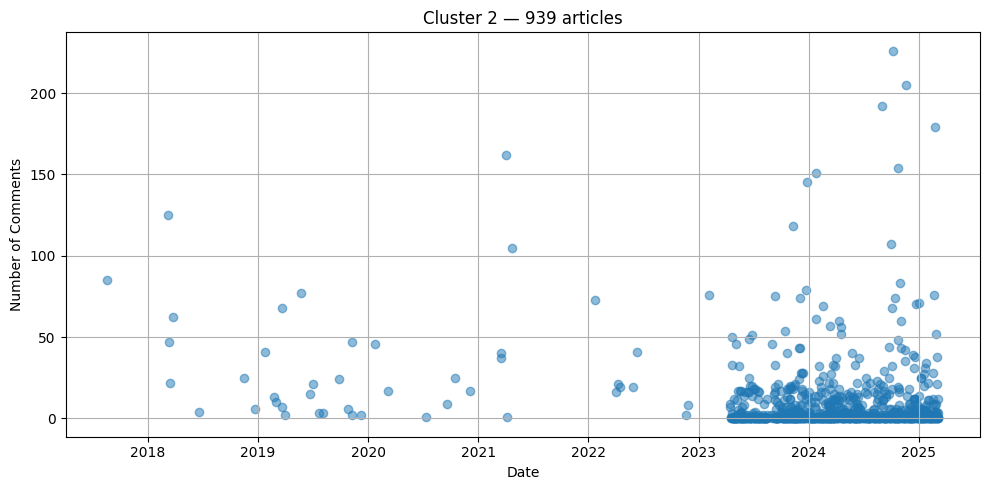

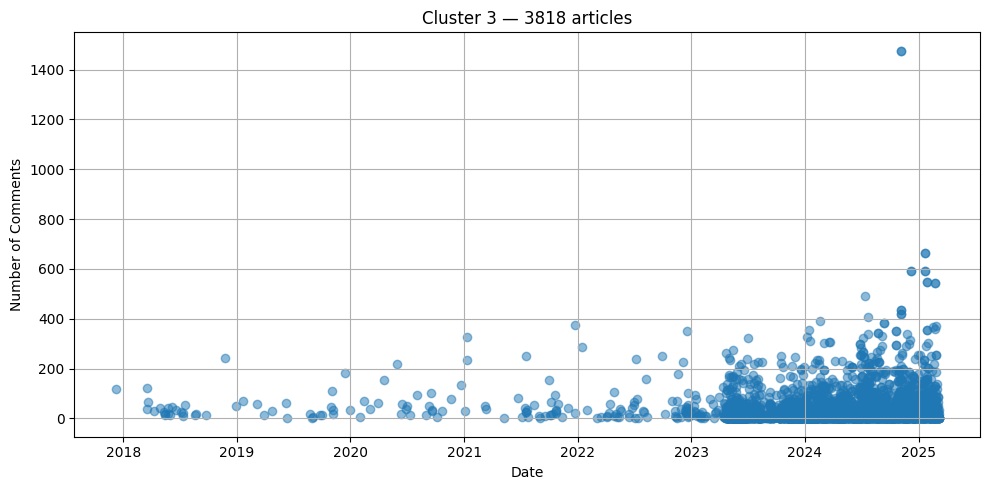

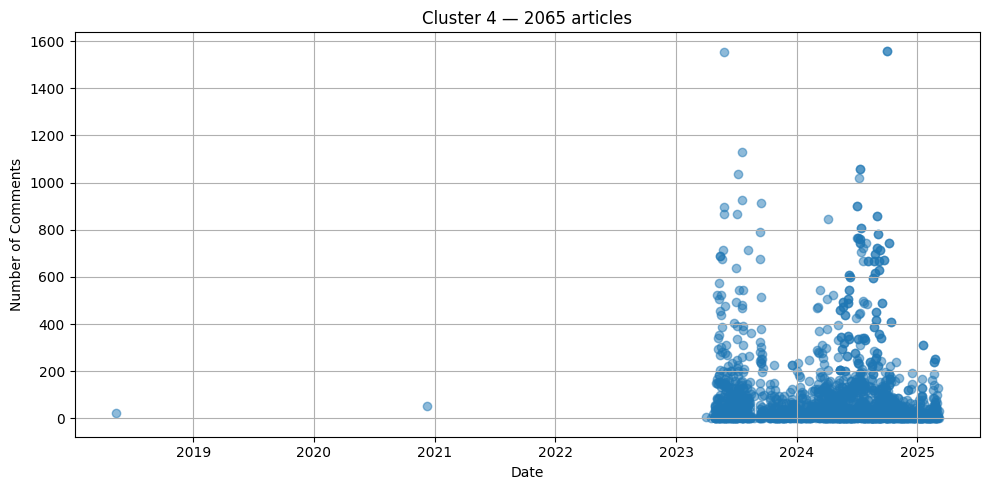

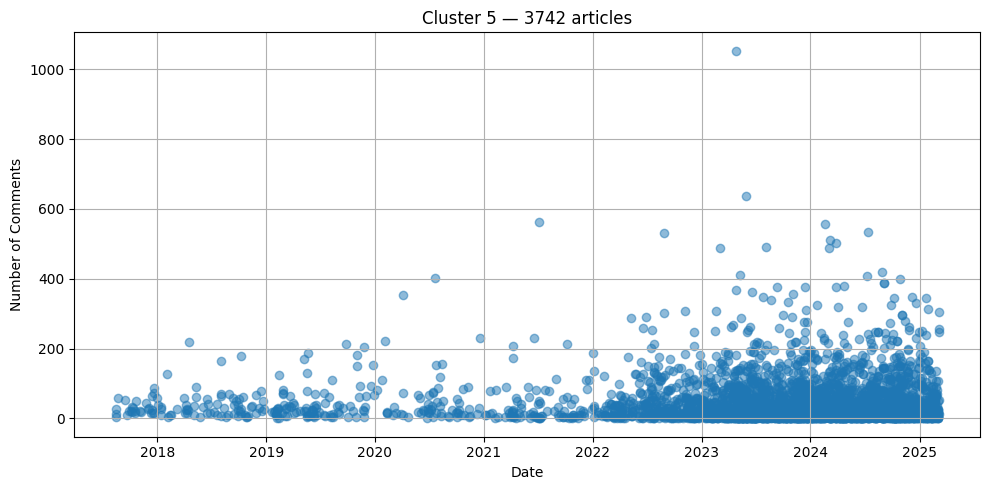

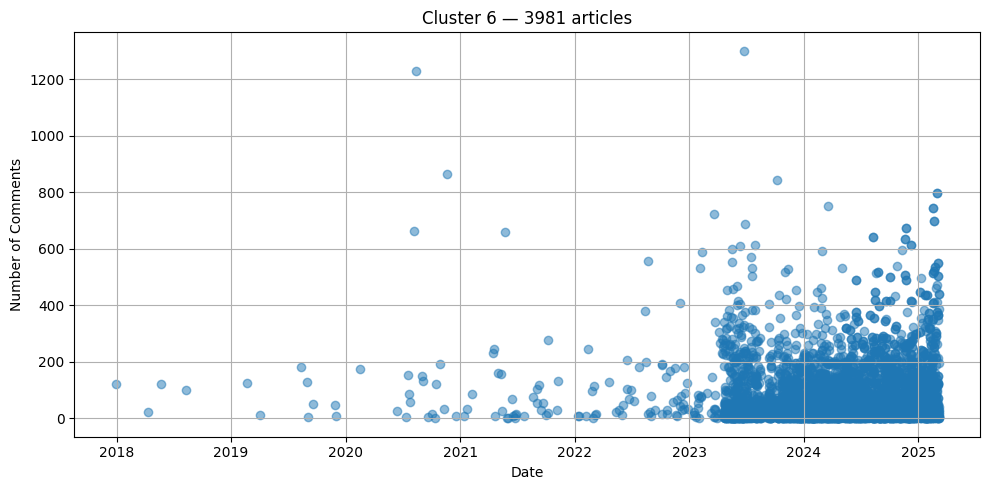

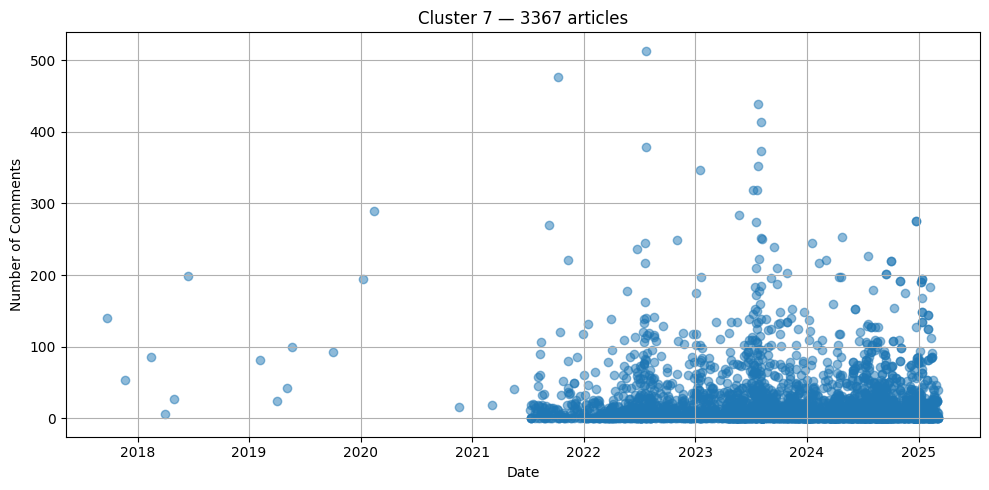

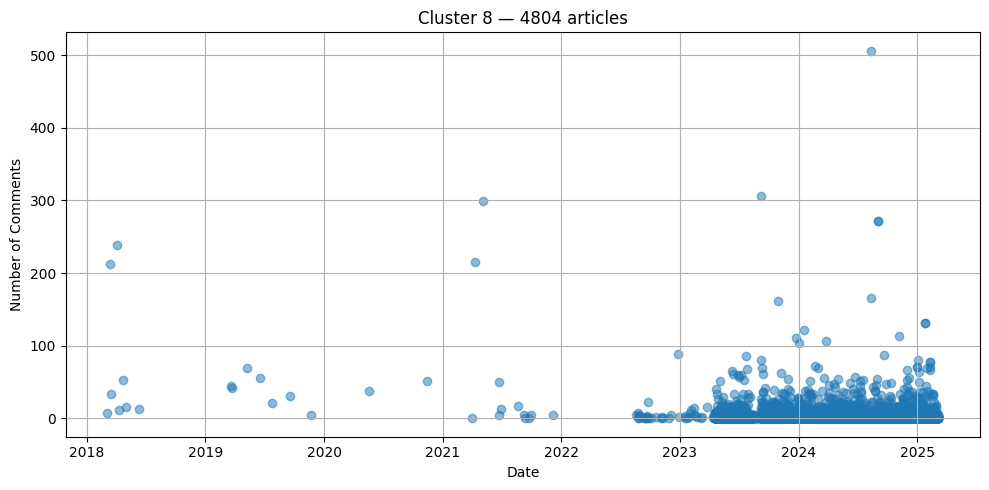

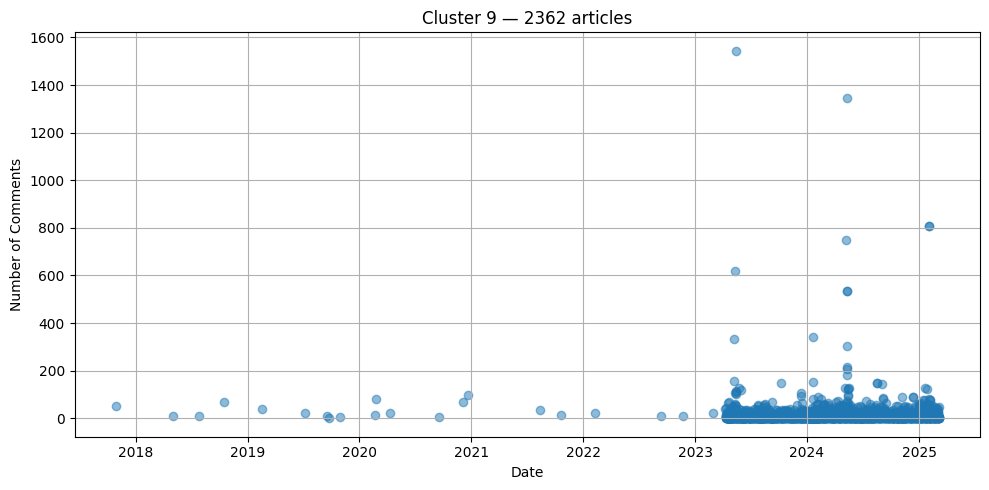

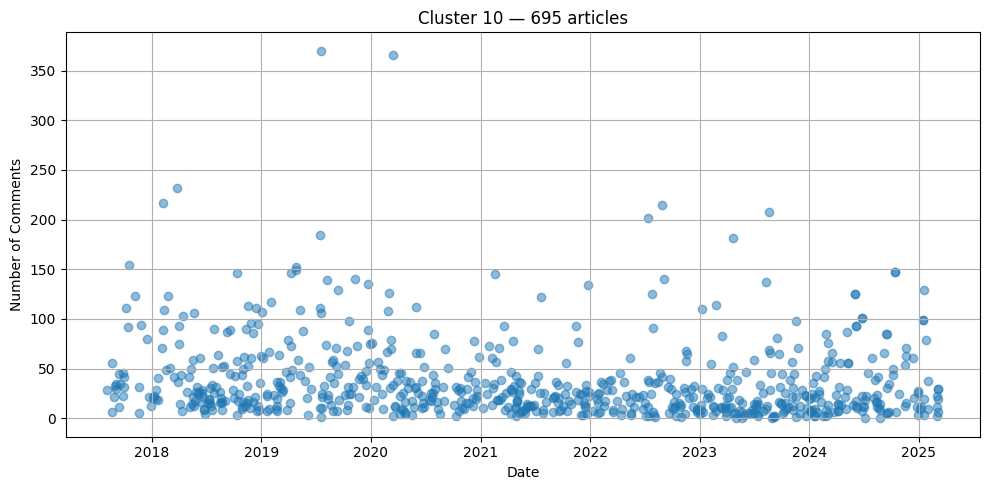

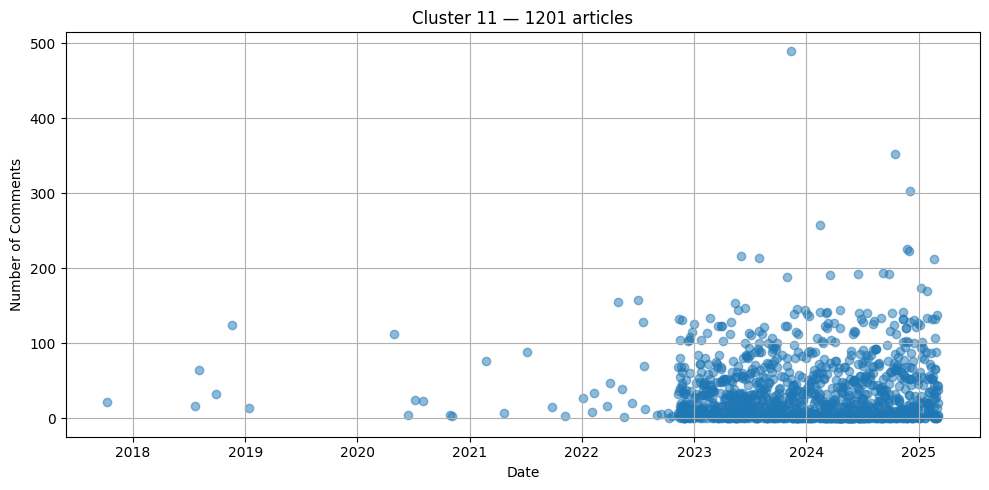

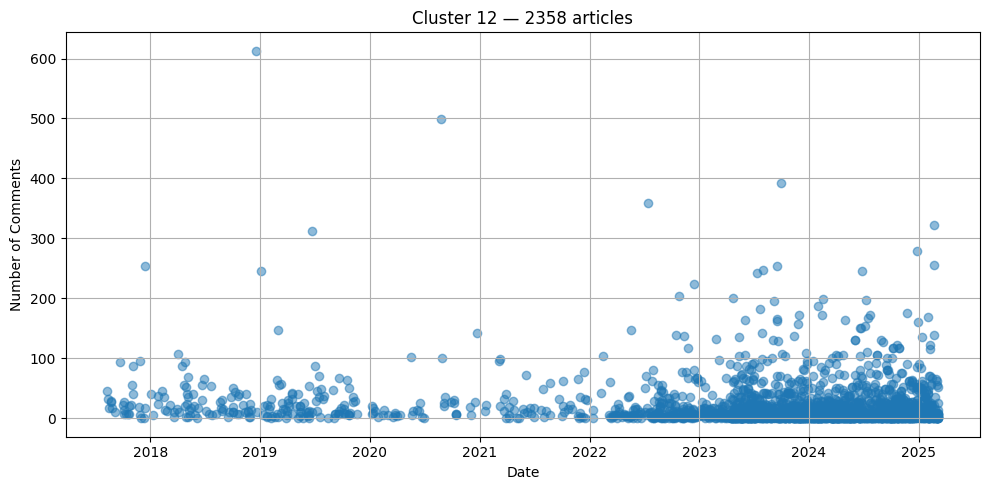

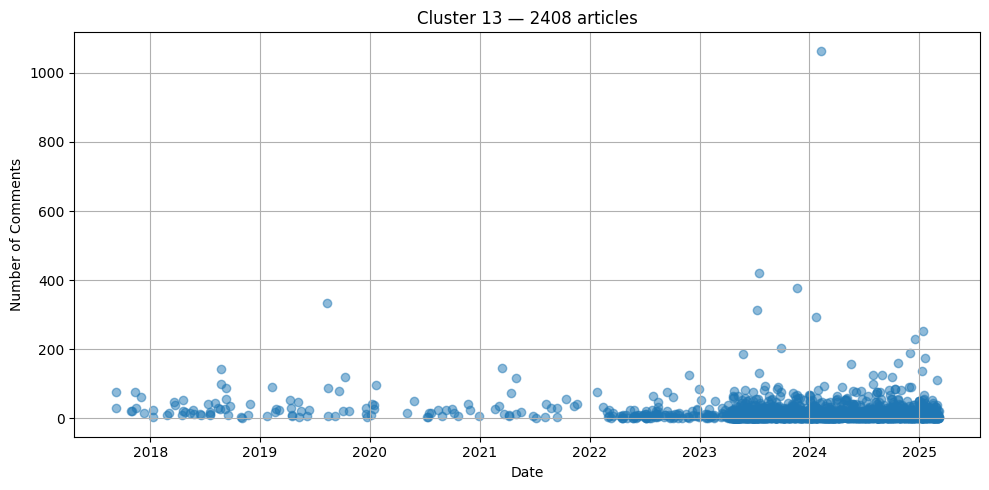

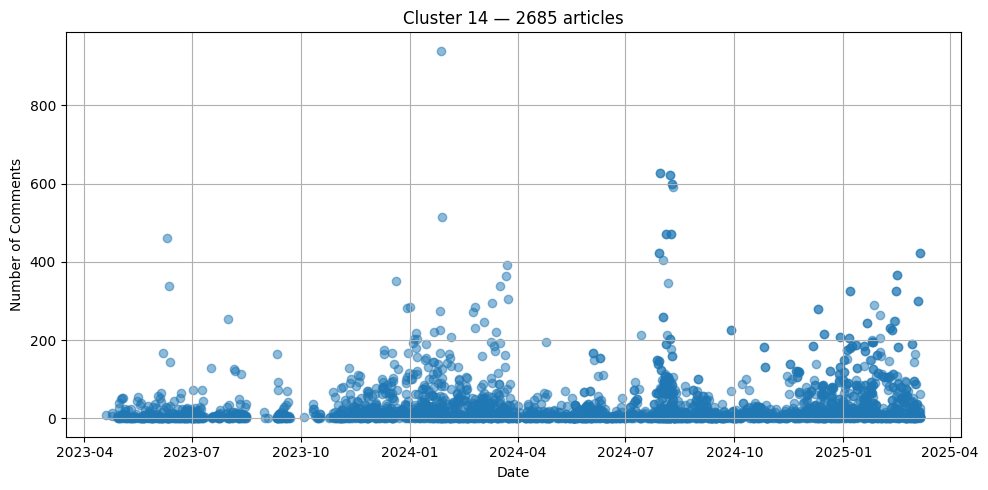

In [2]:
import json
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict

# Load the clustered articles
with open("articles_with_clusters.json", "r", encoding="utf-8") as f:
    articles = json.load(f)

# Group articles by cluster
clusters = defaultdict(list)
for article in articles:
    clusters[article["cluster"]].append(article)

# Plot: One figure per cluster
for cluster_id in sorted(clusters):
    cluster_articles = clusters[cluster_id]
    
    # Extract dates and number of comments
    dates = [datetime.fromisoformat(a["date"]) for a in cluster_articles]
    comments = [a["n_comments"] for a in cluster_articles]
    
    # Create scatter plot
    plt.figure(figsize=(10, 5))
    plt.scatter(dates, comments, alpha=0.5)
    plt.title(f"Cluster {cluster_id} — {len(cluster_articles)} articles")
    plt.xlabel("Date")
    plt.ylabel("Number of Comments")
    plt.grid(True)
    plt.tight_layout()
    plt.show()